In [6]:
# %config Completer.use_jedi = False

In [4]:
!ls ../labtestonline_datasets/dataset_files

labtest_dataset.csv
labtest_dataset_full.csv
labtestsonline_Test.csv


In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import requests
import json
import ast
import sys
import spacy
import re

### Preprocess labtestonline dataset

In [39]:
df = pd.read_csv('../labtestonline_datasets/dataset_files/labtestsonline_Test.csv')

In [40]:
df.head()

,url,title,also_khown_as,formal_name,last_reviewed,last_modified,body
0,https://labtestsonline.org/tests/serum-free-li...,Serum Free Light Chains,"['Free Light Chains', 'SFLC', 'FLC', 'Kappa an...","['Light Chains, Free', 'Free Kappa/Lambda Ratio']","June 4, 2017.","January 21, 2021.",{'At a Glance': 'At a Glance\nWhy Get Tested?\...
1,https://labtestsonline.org/tests/cyclosporine,Cyclosporine,[],[],"February 14, 2018.","February 20, 2020.",{'At a Glance': 'At a Glance\nWhy Get Tested?\...
2,https://labtestsonline.org/tests/hdl-cholesterol,HDL Cholesterol,"['HDL', 'HDL-C']",['High-density Lipoprotein Cholesterol'],"February 26, 2020.","April 20, 2021.",{'At a Glance': 'At a Glance\nWhy Get Tested?\...
3,https://labtestsonline.org/tests/blood-smear,Blood Smear,"['Peripheral Smear', 'Blood Film', 'Manual Dif...",['Peripheral Blood Smear'],"July 27, 2018.","April 20, 2021.",{'At a Glance': 'At a Glance\nWhy Get Tested?\...
4,https://labtestsonline.org/tests/parvovirus-b19,Parvovirus B19,"['Parvovirus', 'Parvo B19']",[],"July 10, 2017.","September 22, 2020.",{'At a Glance': 'At a Glance\nWhy Get Tested?\...


In [85]:
data = []
for row in df.iterrows():
    new_row = list(row[1])[:-1]
    body = ast.literal_eval(list(row[1])[-1].replace('See More\\nSee Less','').replace('See More Common Questions\\nSee Less Common Questions',''))  
    q_a = dict()
    for key in body.keys():
        value = body.get(key)
        if key != 'View Sources' and value.find('?')>0:
#             value.replace('')
            lines = value.split('\n')
            ans = ''
            qus = ''
            find_q = False
            for line in lines:
#                 print(line)
#                 input()
                if line.find('?')>0:
                    if find_q:
                        if len(qus)<150:
                            if qus.strip().find('    ')>0:
                                qus = re.sub('.*\s\s\s\s','',qus)
#                                 print(qus.strip(), '|||', ans, end='\n\n')
                            q_a[qus] = ans.strip()
                        ans = ''
                        find_q = False
                    tmp = line.split('?')
                    if len(tmp[1])>2:
                        q = tmp[0].strip()+'?'
                        a = tmp[1].strip()
                        if len(q)<150:
                            if q.strip().find('    ')>0:
                                q = re.sub('.*\s\s\s\s','',q)
#                                 print(q.strip(), '|||', a, end='\n\n')
                            q_a[q] = a
                    else:
                        find_q = True
                        qus = line.strip()
                elif find_q:
                    ans = ans + line+'\n'
            if qus != '' and len(qus)>3 and len(qus)<150:
                if qus.find('   ')>0:
                    qus = re.sub('.*\s\s\s\s','',qus)
#                     print(qus, '|||', ans, end='\n\n')
                q_a[qus] = ans.strip()
    
    for qus,ans in q_a.items():
        tmp = new_row.copy()
        tmp.append(qus)
        tmp.append(ans)
        data.append(tmp)
#     break

In [88]:
new_df = pd.DataFrame(data,columns=['url','title','also_khown_as','formal_name','last_reviewed','last_modified','question','answer'])
new_df.describe()

,url,title,also_khown_as,formal_name,last_reviewed,last_modified,question,answer
count,4521,4521,4521,4521,4521,4521,4521,4521
unique,364,364,322,165,287,88,1445,4036
top,https://labtestsonline.org/tests/kidney-stone-...,Celiac Disease Antibody Tests,[],[],"September 19, 2018.","March 25, 2021.",What is being tested?,None
freq,19,19,353,2355,53,724,326,184


In [89]:
new_df.to_csv('../labtestonline_datasets/dataset_files/labtestsonline_Test_q_a.csv', index=False)

### Plot question frequency

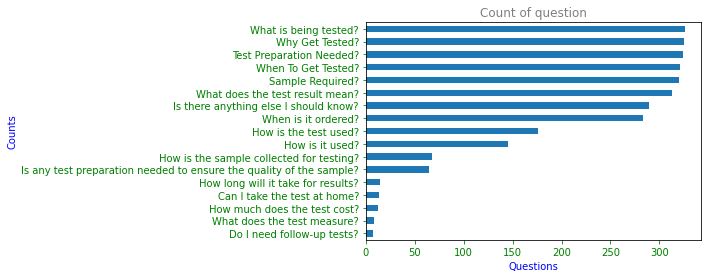

In [91]:
df_labtestonline = pd.read_csv('../labtestonline_datasets/dataset_files/labtestsonline_Test_q_a.csv')
fig, ax = plt.subplots()
ax.set_title('Count of question')
ax.title.set_color('gray')
ax.set_xlabel('Questions')
ax.set_ylabel('Counts')
ax.xaxis.label.set_color('blue')
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='x', colors='green')
ax.tick_params(axis='y', colors='green')
df_labtestonline.question.value_counts().sort_values()[-17:].plot(ax=ax, kind='barh')
# plt.savefig('question frequency-LabtestOnline.png',bbox_inches='tight', dpi=150)

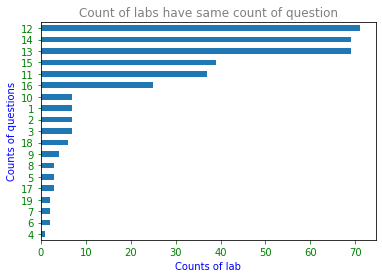

In [92]:
fig, ax = plt.subplots()
ax.set_title('Count of labs have same count of question')
ax.title.set_color('gray')
ax.set_xlabel('Counts of lab')
ax.set_ylabel('Counts of questions')
ax.xaxis.label.set_color('blue')
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='x', colors='green')
ax.tick_params(axis='y', colors='green')
df_labtestonline.title.value_counts().sort_values().value_counts().sort_values().plot(ax=ax, kind='barh')
# plt.savefig('question count frequency-LabtestOnline.png',bbox_inches='tight', dpi=150)

(array([2309.,  898.,  454.,  319.,  302.,  115.,   68.,   32.,   11.,
          13.]),
 array([ 12. ,  25.4,  38.8,  52.2,  65.6,  79. ,  92.4, 105.8, 119.2,
        132.6, 146. ]),
 <BarContainer object of 10 artists>)

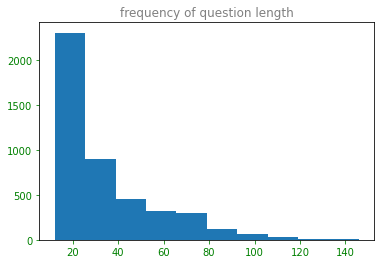

In [93]:
fig, ax = plt.subplots()
ax.set_title('frequency of question length')
ax.title.set_color('gray')
# ax.set_xlabel('Counts of lab')
# ax.set_ylabel('Counts of questions')
ax.xaxis.label.set_color('blue')
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='x', colors='green')
ax.tick_params(axis='y', colors='green')
# df_labtestonline.title.value_counts().sort_values().value_counts().sort_values().plot(ax=ax, kind='bar')
questions_len = [len(i) for i in df_labtestonline.question.values]
plt.hist(questions_len)

In [94]:
max(questions_len)

146

## Questions process

In [98]:
# from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\98938\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\98938\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\98938\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [99]:
"""question preprocess"""
df_labtestonline = pd.read_csv('../labtestonline_datasets/dataset_files/labtestsonline_Test_q_a.csv')
questions = df_labtestonline.question.str.lower()
questions = questions.str.replace('[^\w\s]',' ')

<ipython-input-99-6842a6f56be2>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  questions = questions.str.replace('[^\w\s]',' ')


In [100]:

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
stop = stopwords.words('english')
df_labtestonline['questions_tokens'] = questions.apply(lambda x: [item for item in w_tokenizer.tokenize(x) if item not in stop])
# df_labtestonline.head(5)

In [101]:
questions_clean = df_labtestonline['questions_tokens'].apply(lambda x: ' '.join(x))

In [102]:
questions_clean_uniq = questions_clean.unique()

In [103]:
"""Questions similarity"""
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [138]:

# questions = [str(q) for q in df_labtestonline.question.values]
# questions = questions_tokens.copy()
questions = questions[:100]

In [139]:
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(questions_clean_uniq)

In [140]:
doc_term_matrix = sparse_matrix.todense()
df_vec = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=questions_clean_uniq)
df_vec.head()

,10,100,11,125,15,150,17,18,19,20,...,year,years,yet,yogurt,young,zika,zinc,znt8a,zollinger,zpp
get tested,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sample required,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
test preparation needed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tested,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
used,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
df_vec.loc[['test preparation needed']]

,10,100,11,125,15,150,17,18,19,20,...,year,years,yet,yogurt,young,zika,zinc,znt8a,zollinger,zpp
test preparation needed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
# Compute Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
# frequentCols = df_labtestonline.question.values[:10]
frequentCols = questions_clean.values[:100]
similarity = cosine_similarity(df_vec.loc[frequentCols.tolist()], df_vec)

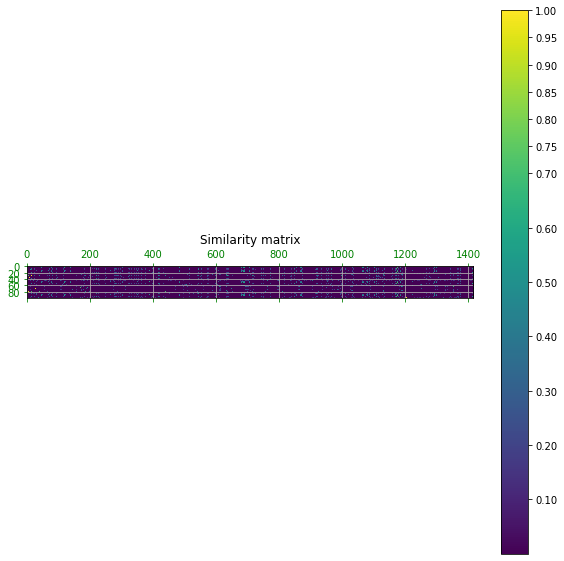

In [143]:
import matplotlib.pyplot as plt
 
# labels = []
# for hood in hood_menu_data:
#     labels.append(hood["properties"]['NAME'])

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(similarity, interpolation='nearest')
ax.grid(True)
ax.tick_params(axis='x', colors='green')
ax.tick_params(axis='y', colors='green')
plt.title('Similarity matrix')
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()


In [144]:
"""Question Clustering"""
# KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans

In [145]:
tfidf_vectorizer = TfidfVectorizer(min_df=13, max_df=0.3)
tfidf = tfidf_vectorizer.fit_transform(questions_clean_uniq)
terms = tfidf_vectorizer.get_feature_names()
print(tfidf_vectorizer.get_feature_names()[:20])
print(len(tfidf_vectorizer.get_feature_names()))
print(tfidf.shape)

['19', 'abnormal', 'addition', 'affect', 'american', 'anti', 'antibodies', 'antibody', 'anything', 'away', 'besides', 'blood', 'cancer', 'cause', 'causes', 'cell', 'cholesterol', 'conditions', 'count', 'covid']
107
(1416, 107)


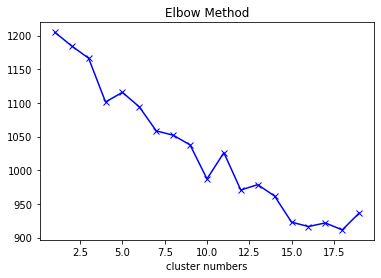

In [146]:
# Using elbow method to determine number of cluster

K = range(1,20)
SSE = []
for k in K:
    kmeans = MiniBatchKMeans(n_clusters = k, batch_size = 50)
    kmeans.fit(tfidf)
    SSE.append(kmeans.inertia_)
    
plt.plot(K,SSE,'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [147]:
# Function to quickly evaluate clustering solutions
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from time import time
def evaluate(clust, X):
    sil = silhouette_score(X, clust.labels_, metric='euclidean')
    # performance.loc[i,'Silhouette'] = sil
    print("Silhouette Score: %.3f" % sil)

    cahr = calinski_harabasz_score(X.toarray(), clust.labels_)
    # performance.loc[i,'Calinski'] = cahr 
    print("Calinski-Harabasz Index: %.3f" % cahr)

    dbs = davies_bouldin_score(X.toarray(), clust.labels_)
    # performance.loc[i,'daviesB'] = dbs
    print("Davies Bouldin Score: %.3f" % dbs)

In [150]:
# Using KMeans to clustering
n_clusters = 10

# for nc in n_clusters:
clust = KMeans(n_clusters=n_clusters)
clust.fit(tfidf)
centers = clust.cluster_centers_.argsort()[:,::-1]
# print("Len of Labels: ",len(set(clust.labels_)), " Params: ", clust.get_params())
for i in range(0,n_clusters):
    word_list=[]
    print("cluster%d:"% i)
    for j in centers[i,:10]:
        word_list.append(terms[j])
    print(word_list) 

cluster0:
['treated', 'diabetes', 'hepatitis', 'infection', 'get', 'deficiency', 'ovarian', 'hiv', 'vitamin', 'heart']
cluster1:
['tested', 'disease', 'levels', 'blood', 'level', 'risk', 'cause', 'mean', 'heart', 'treatment']
cluster2:
['doctor', 'done', 'test', 'office', 'testing', 'performed', 'ordered', 'would', 'might', 'laboratory']
cluster3:
['tests', 'done', 'might', 'may', 'addition', 'performed', 'besides', 'need', 'ordered', 'difference']
cluster4:
['used', 'test', 'tests', 'see', 'testing', 'cancer', 'ovarian', 'determine', 'else', 'blood']
cluster5:
['get', 'infection', 'test', 'antibodies', 'anything', 'covid', '19', 'vitamin', 'treated', 'disease']
cluster6:
['long', 'take', 'results', 'need', 'test', 'medicine', 'result', 'time', 'anti', 'get']
cluster7:
['testing', 'infection', 'prevent', 'genetic', 'sample', 'medlineplus', 'library', 'medicine', 'national', 'everyone']
cluster8:
['healthcare', 'practitioner', 'office', 'provider', 'tell', 'test', 'would', 'done', 'perf

In [151]:
evaluate(clust,tfidf)

Silhouette Score: 0.125
Calinski-Harabasz Index: 36.556
Davies Bouldin Score: 2.619


In [253]:
# clust=KMeans()
# params={
#     'n_clusters': np.arange(10,20,5),
#     'init': ['k-means++','random'],
# #     'n_init':[10,20],
#     'precompute_distances':[True,False,"auto"]
# }
# evaluate_clust(clust,params,features='tfidf',i=0)

In [124]:
# Nearest question to each question
questions_unique = list(set(df_labtestonline.question.str.lower()))
tfidf_vectorizer = TfidfVectorizer(min_df=10, max_df=1.0)
tfidf = tfidf_vectorizer.fit_transform(questions_unique)
terms = tfidf_vectorizer.get_feature_names()
print(tfidf_vectorizer.get_feature_names()[:20])
print(len(tfidf_vectorizer.get_feature_names()))
print(tfidf.shape)

similarity_matrix = cosine_similarity(tfidf,tfidf)

['19', 'abnormal', 'about', 'addition', 'affect', 'after', 'again', 'all', 'always', 'am', 'american', 'an', 'and', 'anti', 'antibodies', 'antibody', 'any', 'anything', 'are', 'as']
202
(1441, 202)


In [125]:
len(questions_unique)

1441

In [126]:
similarity_matrix = cosine_similarity(tfidf,tfidf)
for n in range(50):
    similarity_matrix[n,similarity_matrix[n].argmax()] = 0
    a = similarity_matrix[n].argmax()
#     print(a, similarity_matrix[n][a-2:a+2])
#     break
    if similarity_matrix[n,a]>0.0:
        print(a, similarity_matrix[n,a])
        print(questions_unique[n],'\n'+questions_unique[a], end='\n\n')

616 0.8208813310930506
do i really have to filter all of my urine for this test? 
do i really need to save all of my urine for 24 hours?

161 0.9186558002751128
is there anything i can do to lower my ld? 
is there anything i can do to lower my ige level?

42 0.8875510603259952
should everyone with lung cancer have alk mutation testing? 
should everyone with cancer have kras mutation testing?

271 1.0
what is arthrocentesis and how is it performed? 
what is a lumbar puncture (spinal tap) and how is it performed?

966 0.6377443417103116
will i be monitored differently after the test? 
why not use the ffn test after 35 weeks?

456 0.9751489948861484
how long will it take to get my results? 
how long will it take to get results?

646 0.5989632752617036
i am taking the drug primidone. why is my doctor monitoring phenobarbital? 
why does my doctor want to know all of the medications and supplements i am taking?

135 1.0000000000000002
my chloride level is only slightly out of range. what doe

In [128]:
similarity_matrix = cosine_similarity(tfidf,tfidf)
n = 5
similarity_matrix[n,similarity_matrix[n].argmax()] = 0
a = similarity_matrix[n].argmax()
print(a, similarity_matrix[n][a-2:a+2])
# break
if similarity_matrix[n,a]>0.0:
    print(a, similarity_matrix[n,a])
    print(questions_unique[n],'\n'+questions_unique[a], end='\n\n')

456 [0.06871128 0.         0.97514899 0.10488654]
456 0.9751489948861484
how long will it take to get my results? 
how long will it take to get results?



In [129]:
df_labtestonline[df_labtestonline['question']=='See "How is it used?'].answer.values

array(['" under Common Questions below for details on AFB tests.'],
      dtype=object)

In [130]:
# Question clustring with SentenceTransformer
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import random

In [156]:
df_labtestonline = pd.read_csv('../labtestonline_datasets/dataset_files/labtestsonline_Test_q_a.csv')
questions = df_labtestonline.question.unique().tolist()

In [157]:
test_cases = random.sample(range(0, len(questions) - 1), 30)
model = SentenceTransformer('paraphrase-mpnet-base-v2')
sentence_embeddings = model.encode(questions)
sentence_embeddings.shape

(1445, 768)

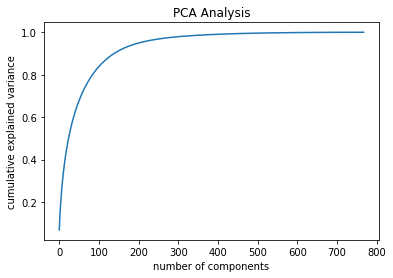

In [133]:
pca = PCA().fit(sentence_embeddings)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA Analysis')
# plt.ylim(0,100.5)
# plt.figure(figsize=(12,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [193]:
n_dimention = 150
pca = PCA(n_components=n_dimention)
reduced_data = pca.fit_transform(sentence_embeddings)
reduced_data.shape

(1445, 150)

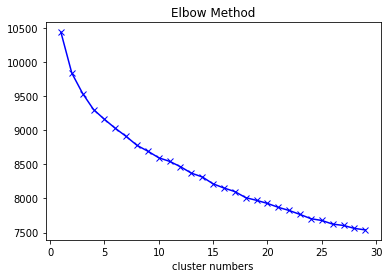

In [194]:
SSE = []

for k in range(1, 30):
    kmeans = KMeans (n_clusters = k)
    kmeans.fit (reduced_data)
    SSE.append (kmeans.inertia_)
    
plt.plot(range(1, 30), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [195]:
n_clusters = 7

km = KMeans(n_clusters=n_clusters)

km.fit(reduced_data)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  7  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 7, 'n_init': 10, 'n_jobs': 'deprecated', 'precompute_distances': 'deprecated', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [208]:
predicts = {}
for i in range(n_clusters):
    predicts[i] = []
for i in test_cases:
    predicts[km.predict(reduced_data[i].reshape(-1, 1).T)[0]].append(questions[i])
for i in range(n_clusters):
    print('questions for cluster:', i)
    [print(j) for j in predicts[i]]
    print()

questions for cluster: 0
Why isn't vancomycin more widely used?
Why do I need to avoid live vaccines while I am taking methotrexate?
How is treatment determined?

questions for cluster: 1
American Cancer Society: Can Ovarian Cancer Be Found Early?
Should everyone have an intrinsic factor antibody test?
Should everyone have pharmacogenetic tests performed?
In addition to a reticulocyte count, what other tests may be done?
When should I get Pap smear?
What other laboratory tests might be done if I or my child has a negative cymotrypsin test?
Are there other genetic changes that my healthcare practitioner may test for with leukemia?

questions for cluster: 2
What is infertility?
What are some other details about T cells?
MedlinePlus: National Library of Medicine. What is DNA?
What is AMAS?
Is there anything else I should know?
Why is my family history important?

questions for cluster: 3
Who performs MTHFR testing?
When are the tests ordered?

questions for cluster: 4
Can I get antibodies

### Filtered Back Translation

In [168]:
!pip install -q mtranslate
!pip install -q transformers

In [169]:
import torch
from mtranslate import translate
from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import tqdm

In [170]:
class GoogleBackTranslator():
    def __init__(self, n_diff:int=1):
        # minimum number of differences
        self.n_diff = n_diff

    def __call__(self, sentence:str, languages:list):
        # any languages from fa .... 
        for i, lang in enumerate(languages[:-1]):
            sentence = translate(sentence, from_language=lang, to_language=languages[i+1])
        # the last back to the first element of the languages list
        back_translated = translate(sentence, from_language=languages[i+1], to_language=languages[0])
        tokens = set(back_translated.split(' '))
        if len(tokens.intersection(sentence.split(' '))) >= len(tokens)-self.n_diff:
            return ''
        return back_translated

In [178]:
bk = GoogleBackTranslator(n_diff=2)
bk("what's up buddy?", ['en', 'ru'])

''

In [191]:
class SentenceSimilarity():
    def __init__(self, max_len=16, model_name='m3hrdadfi/bert-fa-base-uncased-wikitriplet-mean-tokens'):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).eval()
        self.max_len = max_len

    def __call__(self, text:list):
        # tokenization step
        tokens = self.tokenizer(text, truncation=True, padding='max_length', 
                                max_length=self.max_len, return_tensors='pt')

        # model.forward step
        with torch.no_grad():
            embeddings = self.model(**tokens).last_hidden_state
        # Create masked embeddings (just expend size)
        mask = tokens['attention_mask'].unsqueeze(-1).expand(embeddings.shape).float()
        # create sentence embedding (sum embs / sum mask)
        sentence_embeddings = torch.sum(embeddings * mask, dim=1) / torch.clamp(mask.sum(1), min=1e-9) 
        # expand dim for each embedding (helpful for cosine similarity)
        return sentence_embeddings.unsqueeze(1)

    def cosine_similarity(self, a:str, b:str):
        a, b = self([a, b])
        return torch.cosine_similarity(a, b).item()

In [192]:
ss = SentenceSimilarity(max_len=32)

404 Client Error: Not Found for url: https://huggingface.co/m3hrdadfi/bert-en-base-uncased-wikitriplet-mean-tokens/resolve/main/config.json


OSError: Can't load config for 'm3hrdadfi/bert-en-base-uncased-wikitriplet-mean-tokens'. Make sure that:

- 'm3hrdadfi/bert-en-base-uncased-wikitriplet-mean-tokens' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'm3hrdadfi/bert-en-base-uncased-wikitriplet-mean-tokens' is the correct path to a directory containing a config.json file



In [184]:
 ss.cosine_similarity(a="what causes pancreatic insufficiency?", b='what causes male infertility?')

0.8863288164138794

In [187]:
class FilteredBackTranslation():
      # TODO: Parrallel BackTranslator
    def __init__(self, min_score:float=.8, n_diff:int=1, similar_model_name:str='m3hrdadfi/bert-fa-base-uncased-wikitriplet-mean-tokens'):
        self.min_score = min_score
        self.back_translator = GoogleBackTranslator(n_diff=n_diff)
        self.sentence_similar = SentenceSimilarity(model_name=similar_model_name)
        # I found that the following languages work well for Persian back translation
        self.languages = [['en', 'fa'], ['en', 'ru'], ['en', 'ar'], ['en', 'fr']]

    def __call__(self, sentences:list, top_chain:int=2):
        # top chain: use all those 4 languages for creating backtranslation
        augmented = []
        for i, s in tqdm(enumerate(sentences), total=len(sentences)):
            paraphrazes = []
            scores = []
            for langs in self.languages[:top_chain]:
                aug = self.back_translator(s, languages=langs) 
                if aug not in paraphrazes:
                    score = self.sentence_similar.cosine_similarity(s, aug)
                    if score >= self.min_score:
                        scores.append(score)
                        paraphrazes.append(aug)

        if len(scores)>0:
            augmented.append({'id': i, 'org': s, 'aug': paraphrazes, 'score': scores})

        return augmented

In [188]:
augmenter = FilteredBackTranslation(min_score=.9)

In [190]:
sentences = ['Are there other genetic changes that my healthcare practitioner may test for with leukemia?']
augmenter(sentences, top_chain=4) 

  0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 0,
  'org': 'Are there other genetic changes that my healthcare practitioner may test for with leukemia?',
  'aug': ['Are there other genetic changes that my healthcare provider might test for leukemia?',
   'Are there other genetic changes my doctor can test for leukemia?',
   'Are there other genetic changes my healthcare practitioner might experience with leukemia?',
   'Are there other genetic changes my healthcare professional can look for with leukemia?'],
  'score': [0.9713664054870605,
   0.9194540977478027,
   0.9506654739379883,
   0.9540624618530273]}]

### Answer Similarity

## NLTK NER 

In [64]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
{(' '.join(c[0] for c in chunk), chunk.label() ) for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize('\n'.join(questions)))) if hasattr(chunk, 'label') }

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\98938\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\98938\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\98938\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\98938\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


{('A1c', 'ORGANIZATION'),
 ('AAT', 'ORGANIZATION'),
 ('ABO', 'ORGANIZATION'),
 ('ACT', 'ORGANIZATION'),
 ('ACTH', 'ORGANIZATION'),
 ('AChR', 'ORGANIZATION'),
 ('ADA', 'ORGANIZATION'),
 ('ADH', 'ORGANIZATION'),
 ('AEDs', 'ORGANIZATION'),
 ('AFB', 'ORGANIZATION'),
 ('AFP', 'ORGANIZATION'),
 ('ALK', 'ORGANIZATION'),
 ('ALT', 'ORGANIZATION'),
 ('AMA', 'ORGANIZATION'),
 ('AMH', 'ORGANIZATION'),
 ('ANCA', 'ORGANIZATION'),
 ('APOE', 'ORGANIZATION'),
 ('ARR', 'ORGANIZATION'),
 ('ASCA', 'ORGANIZATION'),
 ('ASO', 'ORGANIZATION'),
 ('AST', 'ORGANIZATION'),
 ('Abuse Epithelial', 'ORGANIZATION'),
 ('Addison', 'PERSON'),
 ('Alzheimer', 'ORGANIZATION'),
 ('Ascorbic Acid', 'PERSON'),
 ('Average Glucose', 'PERSON'),
 ('B12', 'PERSON'),
 ('B2M', 'PERSON'),
 ('BMP', 'ORGANIZATION'),
 ('BUN', 'ORGANIZATION'),
 ('BUN Reference Range Blood', 'ORGANIZATION'),
 ('Bacteria', 'GPE'),
 ('Bartter', 'PERSON'),
 ('Basophils Besides', 'PERSON'),
 ('Bence Jones', 'PERSON'),
 ('Besides HCV', 'PERSON'),
 ('CA', 'ORGANI

In [85]:
entity_class = ['drag_name', 'test1', 'test2', 'none']

## Tool for labeling intent for questions

In [42]:
import sys
import pandas as pd
class LabelQuestions():
    def __init__(self, cv_path=None, questions_column_name=None, intent_tag_list=[]):
        if cv_path == None:
            raise Exception("Error: [path] can't be empty.")
        if intent_tag_list==[]:
            raise Exception("Error: [intent_tag_list] can't be empty")
        if questions_column_name==None:
            raise Exception("Error: [questions_column_name] can't be empty")
            
        self.path = cv_path
        self.tag_list = intent_tag_list
        self.questions = pd.read_csv(self.path)[questions_column_name].values
        self.intents = []
    def run(self, saved_name=None):
        print('Whats these questions intent?')
        print('Current intent list: ' , self.tag_list)
        print('Print "finish" to finish labeling.')
        counter = 0
        for q in self.questions:
            intent = ''
            while(not intent in self.tag_list):
                intent = input('Type intent for this question: [ '+q+' ]')
                if intent=='finish':
                    self.finishing(counter, saved_name)
                    return
                if intent in self.tag_list:
                    self.intents.append(intent)
                    break
                else :
                    print('ERROR: I done have this tag in our list type one of current intent list.')
            counter += 1
        print(self.intents)
        
    def finishing(self, counter, saved_name):
        self.df = pd.DataFrame(list(zip(self.questions[:counter],self.intents)), columns=['question', 'intent'])
        if saved_name:
            self.df.to_csv('/'.join(self.path.split('/')[:-1])+'/'+saved_name, index=False)
def main():
    args = sys.argv
    intent_tag_list = ['usage_lab','detail_lab','need_lab','during_lab','prepare_lab','risk_lab','result_lab','any_detail_lab']
    LabelQuestions(cv_path=args[1], questions_column_name=args[2], intent_tag_list=intent_tag_list).run(args[3])  
if __name__ == '__main__':
    main()


Whats these questions intent?
Current intent list:  ['yes', 'no', 'maby']
Print "finish" to finish labeling.
Type intent for this question: [ Test Preparation Needed? ]yes
Type intent for this question: [ Why Get Tested? ]no
Type intent for this question: [ Sample Required? ]finish


## Spacy NER

In [4]:
nlp = spacy.load('en_core_web_sm')

In [11]:
doc = nlp(' '.join(questions))

In [7]:
from spacy import displacy

In [12]:
displacy.serve(doc, style='ent')


Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.
